# 01.2 Martingales and Arbitrage  
<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**

- Understand the concept of martingale, submartingale, and supermartingale in discrete time.  
- Establish the connection between arbitrage-free markets and the existence of a risk-neutral measure.  
- Verify numerically that discounted prices are martingales under this measure.

**The notebook is structured in a progressive way:** 

It starts with the mathematical definition and intuition of martingales, then introduces the Fundamental Theorem of Asset Pricing and the concept of a risk-neutral measure.  
Finally, it applies these ideas to the binomial market model, computes the risk-neutral probability $p^*$,  
and verifies in Python that discounted prices indeed form a martingale.  

This section marks the transition from **theoretical structure** (01.1)  
to **applied stochastic reasoning**, serving as a foundation for pricing and replication in later notebooks.


# 1. Why martingales ?

In stochastic finance, **martingales** are the mathematical expression of "fair game."  
They represent processes whose expected future value (given current information) equals the current value.  

$$
E[X_{n+1} \mid \mathcal{F}_n] = X_n
$$

This property captures the idea that (under a proper measure) **no predictable gain** is possible.


# 2. Martingale definitions

Let $(X_n)_{0 \le n \le N}$ be an adapted process to the filtration $(\mathcal{F}_n)$.

- **Martingale:**  
    $E[X_{n+1} \mid \mathcal{F}_n] = X_n$

- **Submartingale:**  
    $E[X_{n+1} \mid \mathcal{F}_n] \ge X_n$

- **Supermartingale:**  
    $E[X_{n+1} \mid \mathcal{F}_n] \le X_n$

Intuitively:
- A **martingale** means no systematic drift (fair game).
- A **submartingale** tends to increase on average (positive drift).
- A **supermartingale** tends to decrease (negative drift).


# 3. Link with arbitrage and risk-neutral measure

### Fundamental theorem 

> A discrete-time market is **free of arbitrage**  
> if and only if there exists a probability measure $\mathbb{P}^*$,  
> equivalent to the real-world measure $\mathbb{P}$,  
> under which all **discounted asset prices** $(\tilde{S}_n)$ are martingales.

Formally:
$$
E^{\mathbb{P}^*}\!\left[\tilde{S}_{n+1} \mid \mathcal{F}_n\right] = \tilde{S}_n.
$$

$\mathbb{P}^*$ is called the **risk-neutral measure**.  
Under this measure, all assets have the same expected return as the risk-free rate.

**Consequences**
- Under $\mathbb{P}^*$, the discounted portfolio value of any self-financing strategy is a martingale.
- Therefore, no systematic way to make profit ⇒ no arbitrage.


# 4. Risk-neutral measure in the binomial model

We reuse the same binomial setting as in 01.1:

- Riskless asset: $S_n^0 = (1+r)^n$
- Risky asset: $S_{n+1}^1 = S_n^1 \times U$ with probability $p^*$,  
  and $S_{n+1}^1 = S_n^1 \times D$ with probability $1 - p^*$

To ensure no arbitrage, we must have:
$$
D < 1 + r < U
$$
and the **risk-neutral probability** is:

$$
p^* = \frac{(1 + r) - D}{U - D}.
$$


# 5. Python simulation : Checking the martingale property

In [2]:
import numpy as np
import pandas as pd

# Parameters
N = 3
S0 = 100
r = 0.05
U = 1.2
D = 0.8

# Risk-neutral probability
p_star = ((1 + r) - D) / (U - D)
p_star

0.6250000000000001

We generate all possible paths :

In [3]:
paths = []
def build_paths(s, n, current):
    if n == N:
        paths.append(current + [s])
    else:
        build_paths(s * U, n + 1, current + [s])
        build_paths(s * D, n + 1, current + [s])

build_paths(S0, 0, [])
S_tree = pd.DataFrame(paths).T
S_tree.index = [f"n={n}" for n in range(N + 1)]
S_tree.columns = [f"ω{i+1}" for i in range(S_tree.shape[1])]
S_tree

,ω1,ω2,ω3,ω4,ω5,ω6,ω7,ω8
n=0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
n=1,120.0,120.0,120.0,120.0,80.0,80.0,80.0,80.0
n=2,144.0,144.0,96.0,96.0,96.0,96.0,64.0,64.0
n=3,172.8,115.2,115.2,76.8,115.2,76.8,76.8,51.2


We compute discounted prices :

In [4]:
beta = np.array([(1 + r) ** (-n) for n in range(N + 1)])
tilde_S_tree = S_tree.mul(beta.reshape(-1, 1))
tilde_S_tree

,ω1,ω2,ω3,ω4,ω5,ω6,ω7,ω8
n=0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
n=1,114.285714,114.285714,114.285714,114.285714,76.190476,76.190476,76.190476,76.190476
n=2,130.612245,130.612245,87.074830,87.074830,87.074830,87.074830,58.049887,58.049887
n=3,149.271137,99.514091,99.514091,66.342728,99.514091,66.342728,66.342728,44.228485


# 6. Check the martingale condition numerically

We verify that

$$E_{P^*}[\tilde{S}_{n+1} \mid \mathcal{F}_n] = \tilde{S}_n.$$

For each step, the conditional expectation isr each step, the conditional expectation is

$$E_{P^*}[\tilde{S}_{n+1}] = p^* \tilde{S}_n(u) + (1-p^*) \tilde{S}_n(d).$$


In [5]:
# Check martingale property for one step
tilde_S_n = tilde_S_tree.loc["n=0", 0] = 100 / (1 + r)**0
tilde_S_next_up = beta[1] * S0 * U
tilde_S_next_down = beta[1] * S0 * D

expected_next = p_star * tilde_S_next_up + (1 - p_star) * tilde_S_next_down
print("Expected discounted next price:", round(expected_next, 4))
print("Current discounted price:", round(tilde_S_n, 4))

Expected discounted next price: 100.0
Current discounted price: 100.0


**Output:** Both values are (almost) identical : the process $\tilde{S}_n$ is indeed a martingale under $\mathbb{P}^*$.


# 7. Illustrative fig : from real-world measure 𝓟 to risk-neutral measure 𝓟\*

To visualise the idea of the risk-neutral measure,  
we simulate the expected evolution of the price under both measures:

- Under the **real-world measure** 𝓟, the expected return includes a positive drift (μ).  
- Under the **risk-neutral measure** 𝓟\*, the drift is replaced by the risk-free rate (r),  
  making the *discounted* price process a martingale.

The result: the curve of discounted prices under 𝓟\* stays flat on average,  
illustrating that there is no predictable profit opportunity.


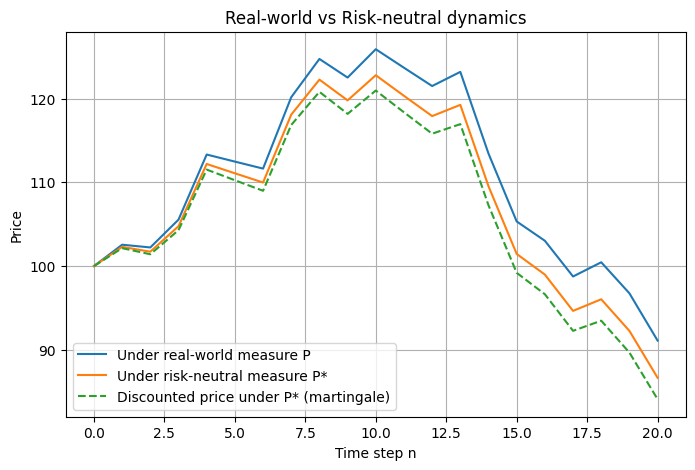

In [7]:
import matplotlib.pyplot as plt

# Parameters
N = 20
S0 = 100
r = 0.03      # risk-free rate
mu = 0.08     # real-world expected return
sigma = 0.2   # volatility
dt = 1/N

np.random.seed(42)

# Simulate one sample path under P (real-world)
Z = np.random.randn(N)
S_real = [S0]
for z in Z:
    S_real.append(S_real[-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z))

# Simulate one path under P* (risk-neutral)
S_rn = [S0]
for z in Z:
    S_rn.append(S_rn[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z))

# Discounted prices under P*
beta = np.exp(-r * np.arange(N + 1) * dt)
S_tilde = np.array(S_rn) * beta

# Plot
plt.figure(figsize=(8,5))
plt.plot(S_real, label="Under real-world measure P", color='tab:blue')
plt.plot(S_rn, label="Under risk-neutral measure P*", color='tab:orange')
plt.plot(S_tilde, '--', label="Discounted price under P* (martingale)", color='tab:green')
plt.title("Real-world vs Risk-neutral dynamics")
plt.xlabel("Time step n")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


We observe:
- The blue curve (under 𝓟) drifts upward due to the real-world expected return μ > r.  
- The orange curve (under 𝓟\*) grows more slowly since the drift is only r.  
- The green dashed curve (discounted price under 𝓟\*)) remains flat on average —  
  confirming that **discounted prices are martingales under the risk-neutral measure**.

This graph visually summarises the Fundamental Theorem of Asset Pricing:
> "No arbitrage ⇔ existence of 𝓟\* such that discounted prices are martingales."
